In [228]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Utility functions
def sigmoid(x, k, x0):
    return 1 / (1 + np.exp(-k * (x - x0)))

def average_altruism_probability(population):
    return sum(individual.altruism_probability() for individual in population) / len(population)


# Individual
class Individual:
    def __init__(self, payoff_altruism, payoff_defect):
        self.payoff_altruism = payoff_altruism
        self.payoff_defect = payoff_defect
        #self.lollipop_benefit = 1
        self.lollipops_received = 0
        self.neighbors = list()
        
    def altruism_probability(self):
        delta_pi = self.payoff_altruism - self.payoff_defect + self.lollipops_received # * self.lollipop_benefit
        return sigmoid(delta_pi, 1, 0)
    
    def __repr__(self):
        return f"{self.lollipops_received}"


def run_iteration(population):
    for individual in population:
                altruism_probability = individual.altruism_probability()
                for neighbor in individual.neighbors:
                    if altruism_probability > random.random():
                        neighbor.lollipops_received += 1

# Simulation
def run_simulation(population_size, iterations, maximum_number_neighbors, payoff_altruism, payoff_defect):
    # contains generations + 1 averages (because it includes the initial average too)
    average_altruism_probabilities = list()
    # Set up simulation
    population = [Individual(payoff_altruism, payoff_defect) for _ in range(population_size)]
    for individual in population:
        # number of neighbors chosen UAR between 1 and maximum_number_neighbors
        individual.neighbors = random.sample(population, random.randint(1, maximum_number_neighbors))  
        # prohibit an individual from being their own neighbor
        if individual in individual.neighbors:
            individual.neighbors.remove(individual)
    average_altruism_probabilities.append(average_altruism_probability(population))

    graphs = list()
    # Run simulation 
    if iterations != None:
        for _ in range(iterations):
            run_iteration(population)
            average_altruism_probabilities.append(average_altruism_probability(population))
        return average_altruism_probabilities, images
    else:
        iterations = 0
        # max out at 100 iterations
        while average_altruism_probability(population) < 0.95 and iterations < 100:
            run_iteration(population)
            iterations += 1
        return iterations, []

In [229]:
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def create_graph(population):
    G = nx.DiGraph()
    G.add_nodes_from(population)
    for individual in population:
        for neighbor in individual.neighbors:
            G.add_edge(individual, neighbor)
    color_map = [individual.altruism_probability() for individual in population]
    labelsDict = {individual: individual.lollipops_received for individual in population}
    return G, color_map, labelsDict

def plot_graphs(graphs):
    figures = []  # Add your matplotlib figures to this list
    iteration = 0
    for graph, color_map, labelsDict in graphs:
        # Create a figure and axis for the plot

        fig = plt.figure()
        my_pos = nx.spring_layout(graph, seed = 100)
        # Draw the graph using NetworkX's draw() function
        nx.draw(graph, pos=my_pos, labels=labelsDict, arrows=True, node_color=color_map, with_labels=True, node_size=300, edge_color='black', linewidths=0.7, font_size=10)

        # Set a title for the plot
        iteration += 1
        figures.append(fig)
        plt.close()

    # Create a GIF from the figures
    images = []
    for fig in figures:
        # Create a new in-memory image and save the figure to it
        img = Image.new('RGB', fig.canvas.get_width_height())
        d1 = ImageDraw.Draw(img)
        d1.text((10, 10), f"iteration: {iteration}", fill=(255, 0, 0))
        fig.canvas.draw()
        img_data = np.array(fig.canvas.buffer_rgba())
        img.paste(Image.fromarray(img_data), (0, 0))
        images.append(img)

    # Save the images as a GIF
    return images

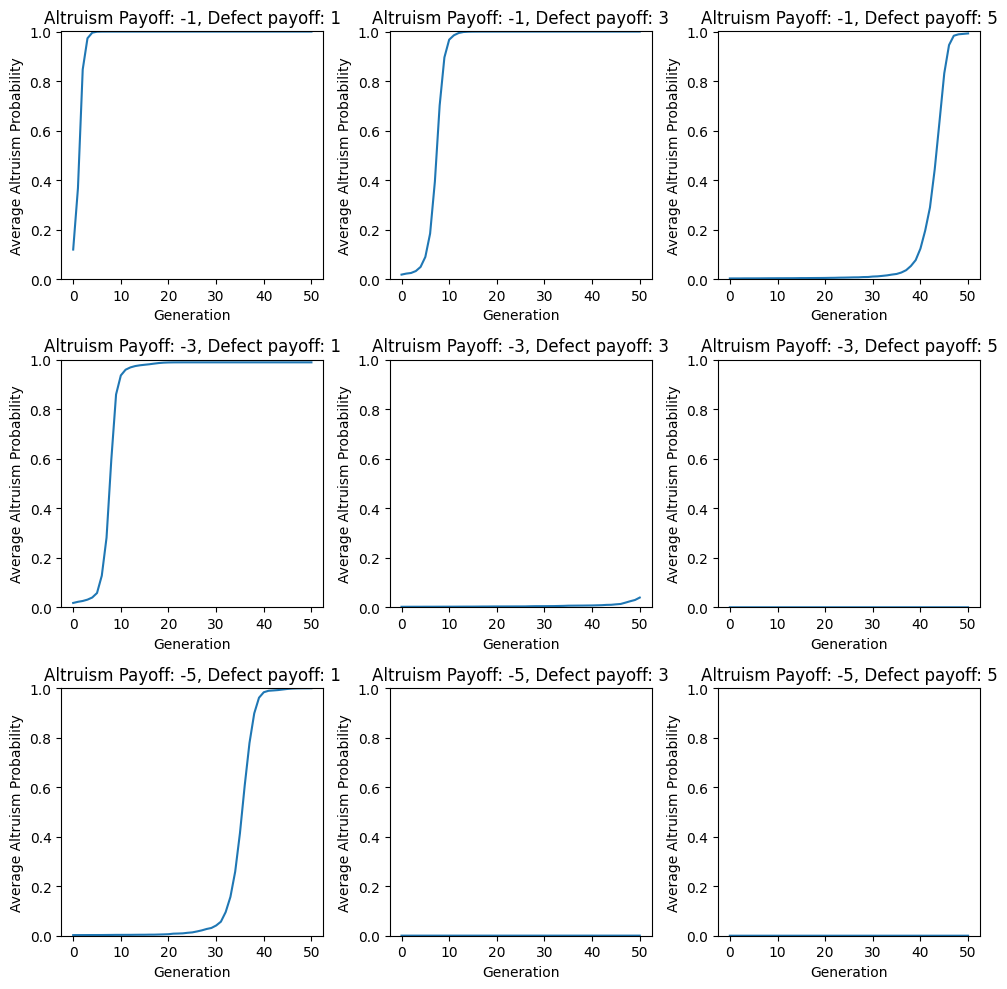

In [230]:
payoff_altruism_values =  [-1, -3, -5]
payoff_defect_values = [1, 3, 5]

fig, axes = plt.subplots(len(payoff_altruism_values), len(payoff_defect_values), figsize=(10, 10))

for i, payoff_altruism in enumerate(payoff_altruism_values):
    for j, payoff_defect in enumerate(payoff_defect_values):
        average_altruism_probabilities, images = run_simulation(population_size=100, 
                                                        iterations=50, 
                                                        maximum_number_neighbors=10, 
                                                        payoff_altruism=payoff_altruism, 
                                                        payoff_defect=payoff_defect)

        # Plot results in corresponding subplot
        ax = axes[i][j]
        ax.plot(average_altruism_probabilities)
        ax.set_title(f'Altruism Payoff: {payoff_altruism}, Defect payoff: {payoff_defect}')
        ax.set_xlabel('Generation')
        ax.set_ylabel('Average Altruism Probability')
        ax.set_ylim(0, 1.001)
        images[0].save(f'animation_{payoff_altruism}_{payoff_defect}.gif', save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
        

plt.tight_layout()
plt.show()

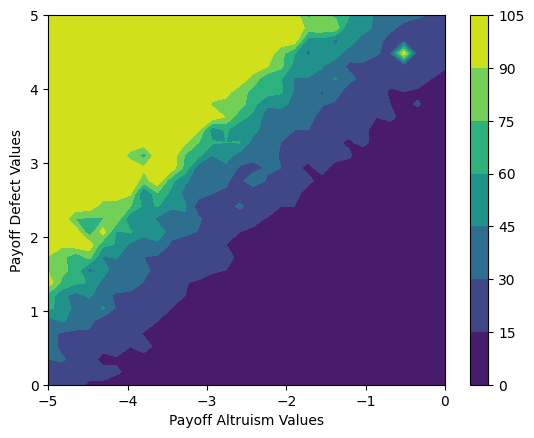

In [231]:

payoff_altruism_values = np.linspace(-5, 0, 30)
payoff_defect_values = np.linspace(0, 5, 30)
X, Y = np.meshgrid(payoff_altruism_values, payoff_defect_values)

iterations = np.zeros_like(X) 

for i in range(iterations.shape[0]):
    for j in range(iterations.shape[1]):
        iterations[i, j], _ = run_simulation(population_size=50, 
                                iterations=None, 
                                maximum_number_neighbors=10, 
                                payoff_altruism=X[i, j], 
                                payoff_defect=Y[i, j])
        

plt.figure()
plt.contourf(X, Y, iterations)
plt.colorbar()
plt.xlabel('Payoff Altruism Values')
plt.ylabel('Payoff Defect Values')
plt.show()


